## **Problema 1:** Análisis y diseño

La dinámica del sistema que se desea controlar se puede sintetizar en la siguiente función de transferencia:

$$G(s)=\frac{\left(s+8\right)}{\left(s+3\right)\left(s+6\right)\left(s+10\right)}$$



a) Se desea diseñar un compensador $D_c(s)$ que satisfaga los siguientes requerimientos:
1. $e_{ss} \le 2\%$ para entradas del tipo escaón en la referencia
2. Sobrepico menor al 20%
3. Tiempo de establecimiento $t_s^{2\%} \le 0.5s$

<center><img src="fig1_exam.png"/></center>


In [1]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
G=ctrl.tf([1,8],[1,3])*ctrl.tf([1],[1,6])*ctrl.tf([1],[1,10])
kp=ctrl.dcgain(G)
G.poles(),G.zeros(),kp

(array([-10.+0.j,  -6.+0.j,  -3.+0.j]),
 array([-8.+0.j]),
 np.float64(0.044444444444444446))

In [3]:
G

TransferFunction(array([1, 8]), array([  1,  19, 108, 180]))

Es un sistema de 3er orden con un cero, a LC el sistema es Tipo 0 respecto a una entrada de referencia

In [4]:
Ess=0.02
kp_deseado = 1/Ess-1

kp_deseado

49.0

In [5]:
Mp=.2

xi=0.46
np.exp(-xi*np.pi/np.sqrt(1-xi**2))

np.float64(0.19641014802711199)

In [6]:
ts=.5 #al 2%
sigma = 4/ts
wn = sigma/xi
wd = wn*np.sqrt(1-xi**2)

plc = -sigma + wd*1j

MF_deseado = xi * 100 # > que, aproximadamente
wc_deseado = wn  # > que, aproximadamente 

sigma, wn, wd, plc, MF_deseado,wc_deseado

(8.0,
 17.391304347826086,
 np.float64(15.442068090729123),
 np.complex128(-8+15.442068090729123j),
 46.0,
 17.391304347826086)

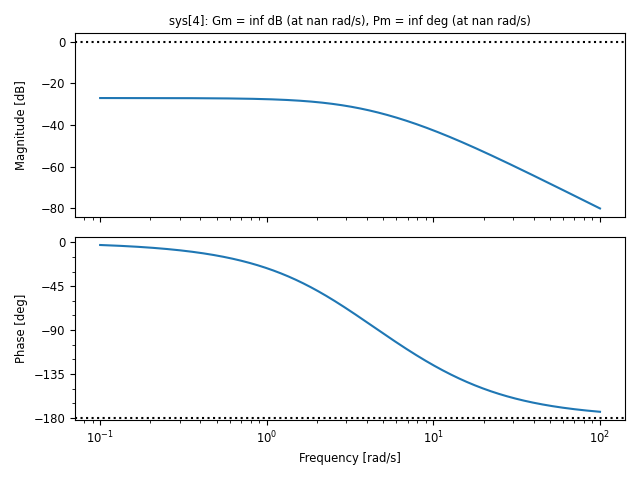

In [7]:
plt.figure()
ctrl.bode(G,dB=True,display_margins=True);
plt.show()


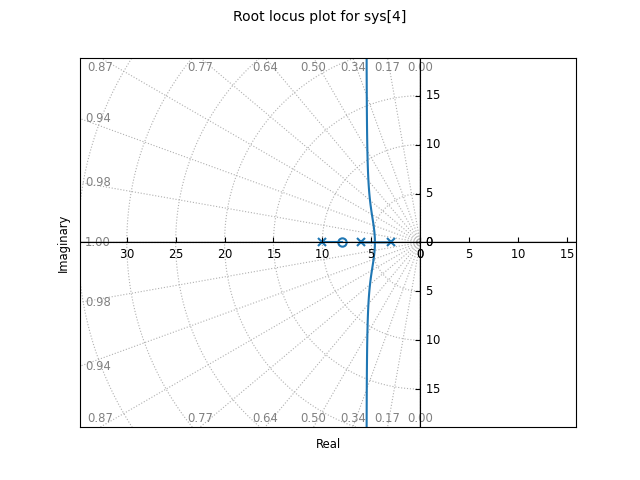

In [8]:
plt.figure()
ctrl.rlocus(G)
plt.show()

Hay muchas formas de comenzar con el control bode o rlocus, 
* resolvemos la frecuencia de y margen de fase y luego vemos que pasa con la ganancia en baja frecuencia.
* resolvemos la ganancia y luego resolvemos la fase

# Diseño:

Elegir wc, mejorar fase con lead y corregir ganancia con un lag

In [28]:
wc =  20 # eligiendo una frecuencia mayor a la de diseño
k1 =1/np.abs(G(wc*1j))#le doy ganancia que fije el wc en donde quiero
k1,ctrl.dcgain(k1*G)

(np.float64(438.35999219661994), np.float64(19.482666319849777))

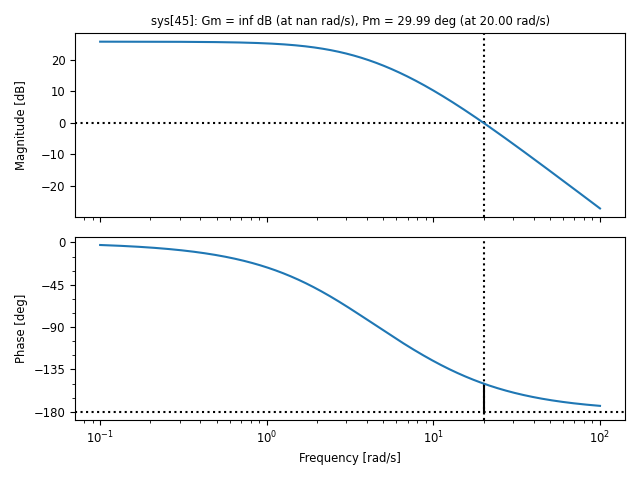

In [29]:
plt.figure()
ctrl.bode(k1*G,dB=True,display_margins=True); #verifico la ganancia
plt.show()

In [30]:
_,pm,_,wpm,_,_=ctrl.stability_margins(k1*G)

Fhi_c = MF_deseado + 10 - pm

Fhi_c


np.float64(26.00634846533208)

In [31]:
alfa=(1-np.sin(Fhi_c*np.pi/180))/(1+np.sin(Fhi_c*np.pi/180))

z=wc*np.sqrt(alfa)
p=wc/np.sqrt(alfa)
z,p,alfa

(np.float64(12.495846437386449),
 np.float64(32.010636654691595),
 np.float64(0.39036544546685903))

In [32]:
Dlead1 = np.sqrt(alfa)*ctrl.tf([1/z,1],[1/p,1]) #ganancia unitaria a baja frecuencia para cumplir wc=20 y MF

Dlead1

TransferFunction(array([0.05      , 0.62479232]), array([0.03123962, 1.        ]))

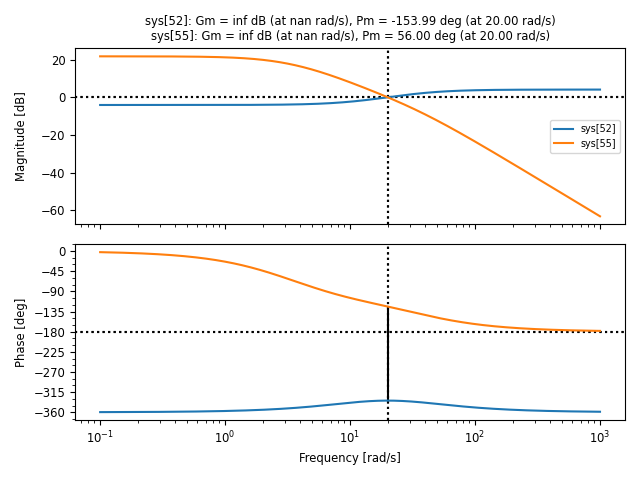

In [33]:
L1=k1*Dlead1*G

plt.figure()
ctrl.bode([Dlead1,L1],dB=True,display_margins=True); 
plt.show()


In [35]:
kp1=L1.dcgain()
kp1

np.float64(12.172620326184187)

Es necesario agregar un lag para cumplir con ganancia en baja frecuencia >50

In [39]:
z_lag1= wc/10
klag1=kp_deseado/kp1

p_lag1 = z_lag1/klag1
Dlag1 = ctrl.tf([1,z_lag1],[1,p_lag1])
Dlag1

TransferFunction(array([1., 2.]), array([1.        , 0.49684165]))

In [40]:
L11=Dlag1*L1

L11.dcgain() 


np.float64(49.00000000000001)

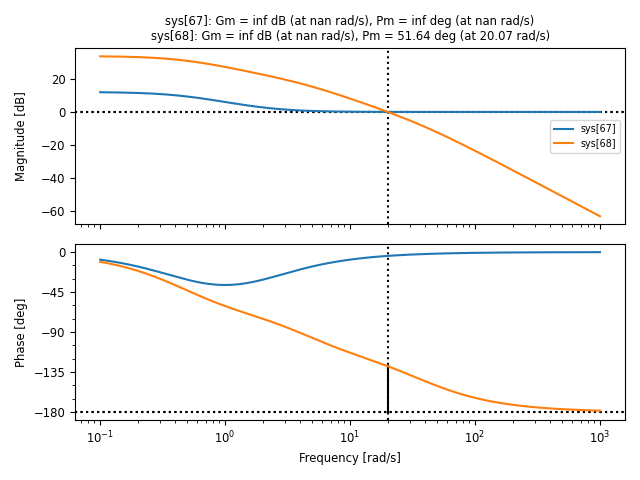

In [41]:

plt.figure()
ctrl.bode([Dlag1,L11],dB=True,display_margins=True); 
plt.show()


b) Verifique el diseño en simulación. Calcule el error de estado estacionario respecto a una entrada de referencia. Estudiar la estabilidad del sistema por medio del criterio de Nyquist. Graficar la señal de control $u(s)$ del sistema ante un escalón unitario en la referencia en $y(s)$.

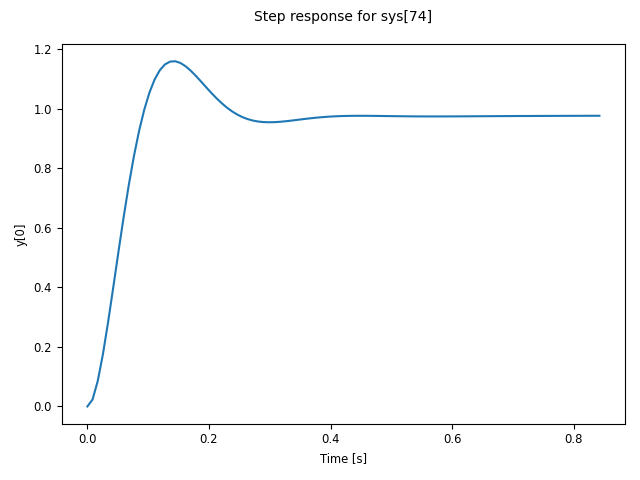

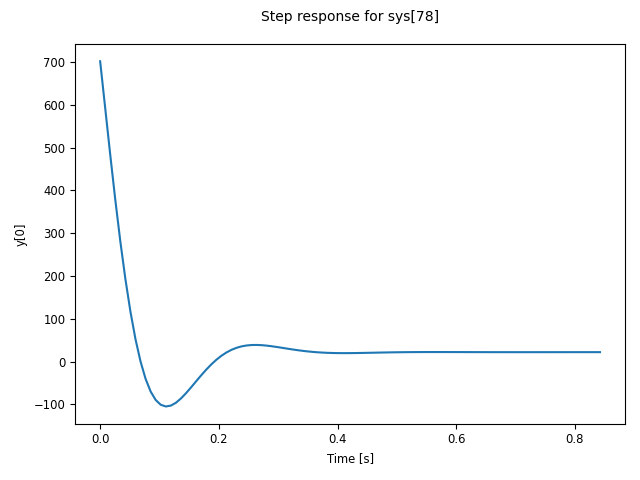

In [42]:
T1=ctrl.feedback(L11)
T1u=ctrl.feedback(k1*Dlead1*Dlag1,G)
plt.figure()
ctrl.step_response(T1).plot()
plt.show()
plt.figure()
ctrl.step_response(T1u).plot()
plt.show()

In [43]:
ctrl.step_info(T1)

{'RiseTime': np.float64(0.059548093811025396),
 'SettlingTime': np.float64(0.34027482177728796),
 'SettlingMin': np.float64(0.9260453977289469),
 'SettlingMax': np.float64(1.1598633064565047),
 'Overshoot': np.float64(18.353398618010687),
 'Undershoot': 0,
 'Peak': np.float64(1.1598633064565047),
 'PeakTime': np.float64(0.14461679925534737),
 'SteadyStateValue': np.float64(0.98)}

## Se logro cumplir las especificaciones estacionario y dinámica!!


c) Se identifica una dinámica adicional a la de $G(s)$ que se representa con un cero de la forma:

$$\left(1-s/100\right)$$

con lo que ahora $G(s)$ queda de la forma:

$$G_2(s)=\frac{\left(1-s/100\right)\left(s+8\right)}{\left(s+3\right)\left(s+6\right)\left(s+10\right)}$$

1. ¿Cómo afectan desde el punto de vista de limitaciones de performance esta nueva dinámica?
2. Verificar si aun se cumplen con los requerimientos antes solicitados y diseñar uno nuevo en caso de que no se cumplan.

d) Verificar  el diseño implementado en c).


In [44]:
G2=ctrl.tf([-0.01,1],[1])*G
G2

TransferFunction(array([-0.01,  0.92,  8.  ]), array([  1,  19, 108, 180]))

La dinámica adicional es un cero en C+ en z=100rad/s por lo que desde el punto de vista de performance, la limitación es para la wc<50rad/s, como el wc del sistema compensado lo elegimos en 20rad/s, en principio no debería afectar el diseño. Aunque esta nueva dinámica podría bajar la fase puesto que esta a menos de una década.

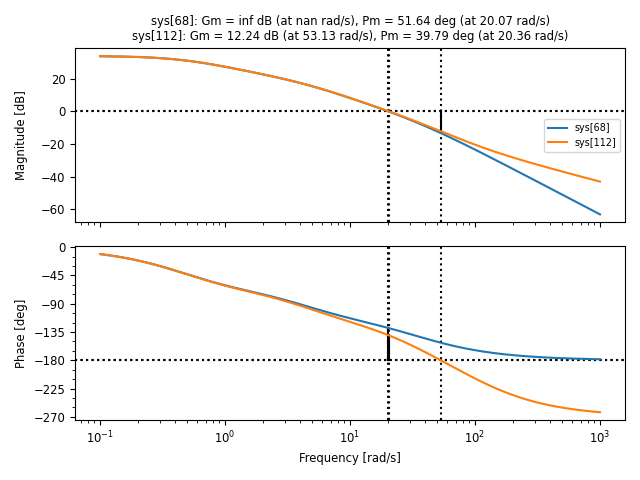

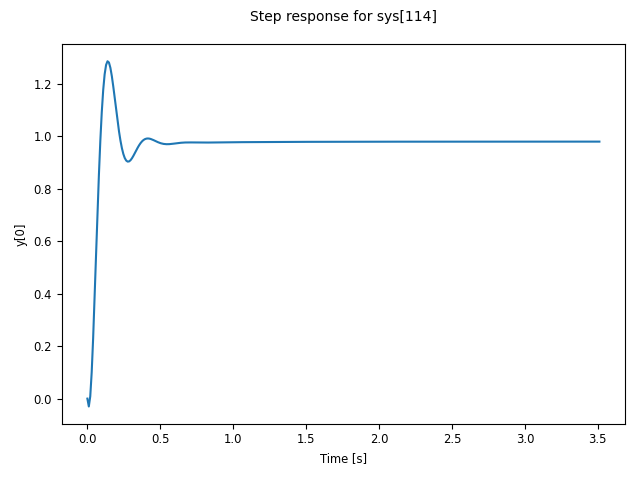

{'RiseTime': np.float64(0.05917360861989084),
 'SettlingTime': np.float64(0.35504165171934504),
 'SettlingMin': np.float64(0.9037440274973869),
 'SettlingMax': np.float64(1.2864127082145487),
 'Overshoot': np.float64(31.26660287903558),
 'Undershoot': np.float64(3.05435119183307),
 'Peak': np.float64(1.2864127082145487),
 'PeakTime': np.float64(0.13807175344641195),
 'SteadyStateValue': np.float64(0.98)}

In [46]:
L2 = k1*Dlead1*Dlag1*G2
T2 = ctrl.feedback(L2)

plt.figure()
ctrl.bode([L11,L2],dB=True,display_margins=True); 
plt.show()

plt.figure()
ctrl.step_response(T2).plot() 
plt.show()
ctrl.step_info(T2) 



finalmente es lo esperado, el cero en C+ baja el margen de fase en al menos 10°, esto disminuye el MF del sistema por lo que aumenta el sobrepico.

Posible solución, podría ser diseña el Lead que aporte 10 o 20 grados extras, porque el lead solo aporta 26° todavía puede aportar mas, no conviene exigir mucho porque probablemente se arruine otra cosa. Otra opción, es correr el lag a frecuencias mas bajas para que no baje tanto el MF del sistema, con esto se puede mejorar hasta 7°. O una combinación de ambas opciones

In [53]:
Fhi_c2 = MF_deseado + 10 + 10 - pm
alfa2=(1-np.sin(Fhi_c2*np.pi/180))/(1+np.sin(Fhi_c2*np.pi/180))
z2=wc*np.sqrt(alfa2)
p2=wc/np.sqrt(alfa2)

Dlead2 = np.sqrt(alfa2)*ctrl.tf([1/z2,1],[1/p2,1]) #ganancia unitaria a baja frecuencia para cumplir wc=20 y MF


z_lag2= wc/10
klag2=kp_deseado/(k1*Dlead2*G2).dcgain()

p_lag2 = z_lag2/klag2
Dlag2 = ctrl.tf([1,z_lag2],[1,p_lag2])
Dlag2

L3=k1*Dlead2*Dlag2*G2
L3.dcgain()

np.float64(48.99999999999999)

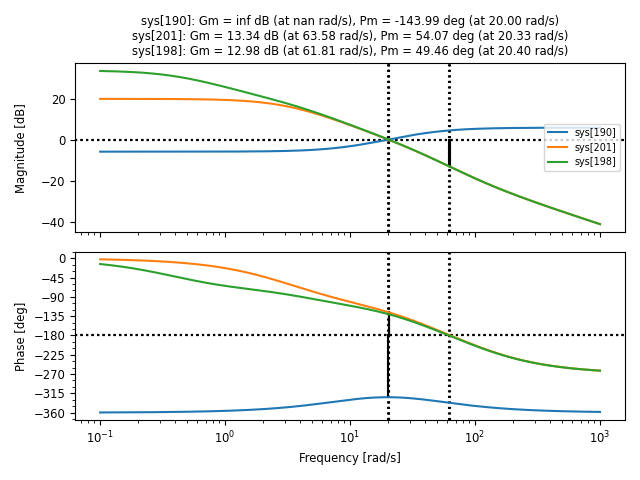

In [54]:
plt.figure()
ctrl.bode([Dlead2,k1*Dlead2*G2,L3],dB=True,display_margins=True); 
plt.show()


C:\Users\juanp\AppData\Local\Temp\ipykernel_11072\3289792582.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


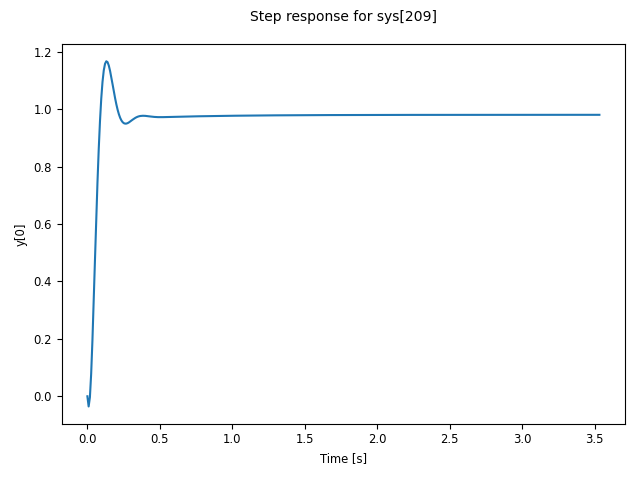

{'RiseTime': np.float64(0.052218090216454995),
 'SettlingTime': np.float64(0.31330854129873),
 'SettlingMin': np.float64(0.949219935290471),
 'SettlingMax': np.float64(1.1664474099925668),
 'Overshoot': np.float64(19.02524591760886),
 'Undershoot': np.float64(3.618635052167599),
 'Peak': np.float64(1.1664474099925668),
 'PeakTime': np.float64(0.13054522554113748),
 'SteadyStateValue': np.float64(0.98)}

In [55]:
T2=ctrl.feedback(L3)
plt.figure()
ctrl.step_response(T2).plot()
plt.show()
ctrl.step_info(T2)


e) Finalmente, es necesario seleccionar un actuador para el sistema dinámico $G_2(s)$ que no afecte el diseño de los compensadores anteriores. ¿Cual sería el valor de $\tau_a$? Si considera que la función de transferencia del actuador es de la forma:

$$G_a=\frac{1}{\tau_a s+1}$$




Como wc del sistema compensado final es 20rad/s el Ta debería ser mayor a 200rad/s es decir 1 década después del wc. Esto no debería afectar grandemente al sistema, pero el MF va a disminuir y por ende aumentaría el sobrepico

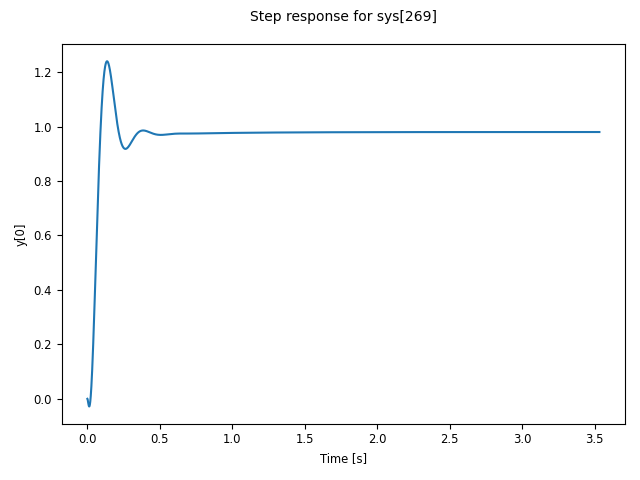

{'RiseTime': np.float64(0.05017313884392203),
 'SettlingTime': np.float64(0.32365207873966606),
 'SettlingMin': np.float64(0.8853735286155978),
 'SettlingMax': np.float64(1.2399014933387094),
 'Overshoot': np.float64(26.520560544766266),
 'Undershoot': np.float64(2.86785759458908),
 'Peak': np.float64(1.2399014933387094),
 'PeakTime': np.float64(0.13567947405680322),
 'SteadyStateValue': np.float64(0.98)}

In [60]:
Ga=ctrl.tf(1,[1/200,1])
T3=ctrl.feedback(Ga*L3)
plt.figure()
ctrl.step_response(T3).plot()
plt.show()
ctrl.step_info(T3)

Lo dicho antes, se observa en el comportamiento del sistema a LC